In [6]:
#GAMZE MADEN
#504202514
#########################
import numpy as np
import matplotlib.pyplot as plt
# Python language software package for the creation, manipulation, and study of the structure, dynamics, and function of complex networks
from networkx import nx, gnm_random_graph, gnp_random_graph, erdos_renyi_graph 
import networkx.algorithms.community as nx_comm
from networkx.algorithms.smallworld import random_reference
import random
import community 
from numpy import linalg as LA
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.io

# QUESTION (1.1) Explain the key steps of Bellman-Ford algorithm (one-by-one). [5%]

function BellmanFord(G, start_ID)
Input: Graph and start_ID 
Output: Array of Nodes, Shortest distance to all vertices from node with start_ID, Previous node from current node. If there is a negative weight cycle, then shortest distances are not calculated, negative weight cycle is reported.

1)Initialize the distance to all nodes to infinity except start_ID which is 0 and array to store previous node


    distance := list of size n
    predecessor := list of size n
    
2)Relaxation step which means approximation of difficult problem using easier one to solve. BellmanFord relaxes all edges (V-1 in V is node count) not only neighbors which makes differentiates it from Dijkstra's. It calculates shorter paths until finding the shortest one from starting node. Also in this step previous nodes stored in array named predecessor. 
    
    repeat |V|−1 times:
         for each edge (u, v) with weight w in edges do
             if distance[u] + w < distance[v] then
                 distance[v] := distance[u] + w
                 predecessor[v] := u


3)Check for negative-weight cycles and report if exists. Here we calculate shortest distance for all nodes one more time and if it finds shorter path than above loop did, means graph has negative cycle. 

      for each edge (u, v) with weight w in edges do
        if distance[u] + w < distance[v] then
            error "Graph contains a negative-weight cycle"
            
4)Return shortest distance and array of which contains previous shortest distanced nodes for each vertex
       
       return distance, predecessor 
 

# QUESTION (1.2) Write a function called BellmanFordAlgo that takes (i) A and (2) astarting node ID as inputs, and outputs an array as in Graph Theory Blink 5.4 a , where each row represents a node in the graph G and comprising three columns (nodes, shortest distance from source input node, previous node). [10%] Use of external libraries is not allowed. Code it up from scratch.

In [7]:
#Implementing Bellman-Ford's Algorithm
def BellmanFordAlgo(A, start_ID):
    #create graph from adjacency matrix
    graph_ = nx.from_numpy_matrix(A,create_using=nx.DiGraph)
    #assign number of nodes to V
    V=graph_.number_of_nodes()
    #initialize dictionary to INFINITE for all nodes except start_ID 
    dist = {i : float("Inf") for i in graph_.nodes}
    #set starting node distance to 0
    dist[start_ID] = 0
    #store previous node from current node which has the shortest distance
    previous_node = [0] * V
    
    #loop for edge count which is (node count-1)
    for temp in range(V-1):
        #inner loop for source node u, target node v and weight between them
        for u, v, w in graph_.edges(data=True):
            #get weight value since w returns dictionary
            a=w["weight"]
            #calculate shortest distance
            if dist[u] != float("Inf")  and dist[u] + a< dist[v]:
                #store distance value for current u and v
                dist[v] = dist[u] + a        
                #store previous node with shortest distance in array
                previous_node[v] = u
                
    #check for negative cycle by looping over all nodes one more time            
    for u, v, w in graph_.edges(data=True):
        a=w["weight"]
        if dist[u] != float("Inf")  and dist[u] + a< dist[v]:
            #report if exists negative cycle
            print("Graph contains negative cycle")
            #exit process
            return
    #print required array in HW 
    print("Node\t\tDistance\tPrevious node")
    for key, value in dist.items(): 
        print("{0}\t\t{1}\t\t{2}".format(key, value,previous_node[key]))  
  

# QUESTION (1.3) Run your function in the Jupyter Notebook on the input adjacency matrix A (see Fig. fig:1) and display the output array. You can find the data inside ‘Exercise 1 data’ folder. [5%]

In [8]:
#get adjacency matrix of HW
mat = scipy.io.loadmat('adjacencyMatrix.mat')
#extract only matrix from mat file whose field name is A 
adjacencyMatrix=mat['A']   
#call function and output reqired array in HW
BellmanFordAlgo(adjacencyMatrix,0)

Node		Distance	Previous node
0		0		0
1		1		0
2		2		0
3		5		1
4		8		3
5		5		2


# QUESTION (2.1) Write a function globalEfficiency, which inputs a graph adjacency matrix A and outputs the global efficiency value. [5%]

In [9]:
def globalEfficiency(A):
    glob_eff=0.0
    #create graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    #assign number of nodes to N
    N=G.number_of_nodes()
    length = dict(nx.all_pairs_dijkstra_path_length(G))
    sigma_=0.0
    for node in G.nodes:
        for inner_node in G.nodes:
            if length[node][inner_node]!=0:
                sigma_+=1/length[node][inner_node]

        
    
    glob_eff = (1/(N*(N-1)))*sigma_
    
    print("E_glob= {0}\t\t".format(glob_eff))
    return glob_eff
    
    

# QUESTION (2.2) Write a function diffusionEfficiency, which inputs a graph adjacency matrix A and outputs the diffusion efficiency value. [5%]

In [10]:
#calculate strength (from previous Homework)
def degree_centrality(G):
    return dict(G.degree(weight = "weight"))

In [11]:
def diffusionEfficiency(A):
    diff_eff=0.0
    #create graph from adjacency matrix
    G = nx.from_numpy_matrix(A)
    #calculate strength of each node
    dict_strength=degree_centrality(G)
    #get only strength values from dictionary object as a list
    values = list(dict_strength.values())
    #cast list to numpy array
    an_array = np.array(values)
    #get node count
    N=G.number_of_nodes()
    #Initialize S matrix NxN 
    S= np.zeros((N, N), float)
    #Diagonally fill matrix S with strength values elements of array
    np.fill_diagonal(S, an_array)
    #I changed variable name to better show formula U=WS**-1
    W=A
    # This will return matrix product of two array
    U = W @ np.linalg.inv(S)
    #create I matrix
    I= np.zeros((N, N), float)
    np.fill_diagonal(I, 1)
    #Initialize sigma 
    Xij=np.zeros((N, N), float)
    for n in range(N):
        for i in range(N):
            if i!=n:
                #sum (n,i) elements of U over all nodes where i != j 
                Xij=np.add(Xij, np.linalg.inv(np.subtract(I, U[n][i])))
                
    sigma_=0
    for n in range(N):
        for i in range(N):
            sigma_ += 1/Xij[n][i]
            
    diff_eff = (1/(N*(N-1)))*sigma_
    print("E_diff= {0}\t\t".format(diff_eff))
    return diff_eff

# QUESTION (2.3) Create a scatter plot where x-axis represents threshold value α ∈ [0 : 0.1 : 0.9] (0.1 denotes the threshold step size) and the y-axis represents the global efficiency E glob of brain graph adjacency matrices ‘Exercise 2 data/ brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’ (Fig. fig:2). By thresholding each adjacency matrix at different threshold values α ∈ [0 : 0.1 : 0.9], examine how its global and diffusion efficiencies change. Use two different colors to compare the change in global efficiency across both brain graphs. [5%]

E_glob= 6.174287370678654		
E_diff= -0.05745376227109758		
E_glob= 13.349421728782737		
E_diff= 0.01204897909449197		
E_glob= 21.51514200050434		
E_diff= -0.31972702112920753		
E_glob= 30.80642225595913		
E_diff= -0.019757518495498227		
E_glob= 36.06626909271474		
E_diff= -0.0013156143216982768		
E_glob= 35.32783792673426		
E_diff= -0.027551020314350912		
E_glob= 59.5758042083578		
E_diff= 0.018904671121805865		
E_glob= 59.891046411176745		
E_diff= 0.00014192806544926448		
E_glob= 58.85610904649689		
E_diff= -0.0034572544485006866		
E_glob= 59.09230732440916		
E_diff= 0.15084643206614476		
E_glob= 38.98934926584445		
E_diff= -0.06799088056376847		
E_glob= 32.421369244277145		
E_diff= -0.016776269574638545		
E_glob= 32.71834623170768		
E_diff= -0.01616195176369703		
E_glob= 33.79719979637053		
E_diff= -0.01781648861552231		
E_glob= 33.787781570608416		
E_diff= 0.016487701242710012		
E_glob= 55.23411424339508		
E_diff= -0.02033526852763777		
E_glob= 53.767769197194085		
E_diff= -0.003111

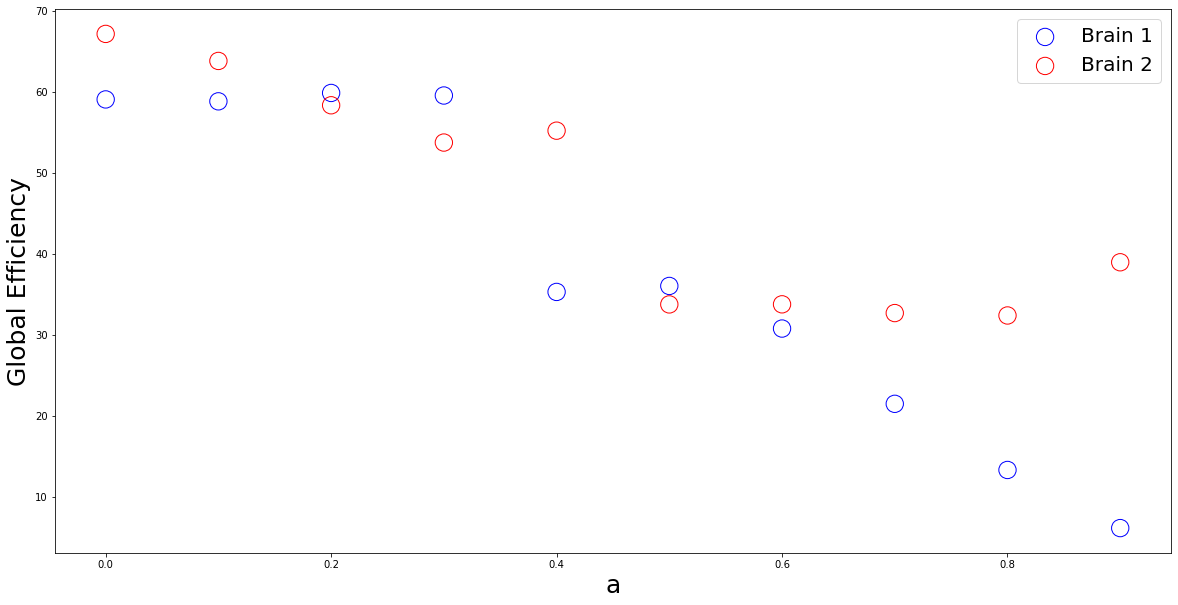

In [12]:
mat = scipy.io.loadmat('brainGraph1.mat')
#extract only matrix from mat file whose field name is A 
#get adjacency matrix of HW2 Brain Graph 1
adjacencyMatrix=mat['W']
num_rows, num_cols = adjacencyMatrix.shape
E_glob_BR1=[]
E_diff_BR1=[]
t_brain_1=[]
t = np.arange(0.1, 1.0, 0.1)
for i in t:
    targetted_num_nodes=round(num_rows*i)
    copied_array=adjacencyMatrix
    a=copied_array[:targetted_num_nodes, :targetted_num_nodes]
    #call function and output reqired array in HW
    E_glob_BR1.append(globalEfficiency(a))
    E_diff_BR1.append(diffusionEfficiency(a))
    #add threshold graph to array for later use
    t_brain_1.append(a)

t_brain_1.append(adjacencyMatrix)
E_glob_BR1.append(globalEfficiency(adjacencyMatrix))
E_diff_BR1.append(diffusionEfficiency(adjacencyMatrix))

#get adjacency matrix of HW2 Brain Graph 2
mat = scipy.io.loadmat('brainGraph2.mat')
#extract only matrix from mat file whose field name is A 
adjacencyMatrix=mat['W']
num_rows, num_cols = adjacencyMatrix.shape
E_glob_BR2=[]
E_diff_BR2=[]
t_brain_2=[]
for i in t:
    targetted_num_nodes=round(num_rows*i)
    copied_array=adjacencyMatrix
    a=copied_array[:targetted_num_nodes, :targetted_num_nodes]
    #call function and output reqired array in HW
    E_glob_BR2.append(globalEfficiency(a))
    E_diff_BR2.append(diffusionEfficiency(a))
    #add threshold graph to array for later use
    t_brain_2.append(a)
    
t_brain_2.append(adjacencyMatrix)
E_glob_BR2.append(globalEfficiency(adjacencyMatrix))
E_diff_BR2.append(diffusionEfficiency(adjacencyMatrix))

E_glob_BR1.reverse()
E_diff_BR1.reverse()
E_glob_BR2.reverse()
E_diff_BR2.reverse()
x = np.arange(0.0, 1.0, 0.1)
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x, E_glob_BR1,marker='o',color='b',s=300,facecolors='none')
ax.scatter(x,E_glob_BR2, marker='o', color='r',s=300,facecolors='none')
ax.legend(labels=['Brain 1', 'Brain 2'],fontsize=20,loc='best')
ax.set_ylabel('Global Efficiency',fontsize=25)
ax.set_xlabel('a',fontsize=25)
plt.show()

# QUESTION (2.4) In a second figure, plot the diffusion efficiency E diff of both matrices against α. [5%]

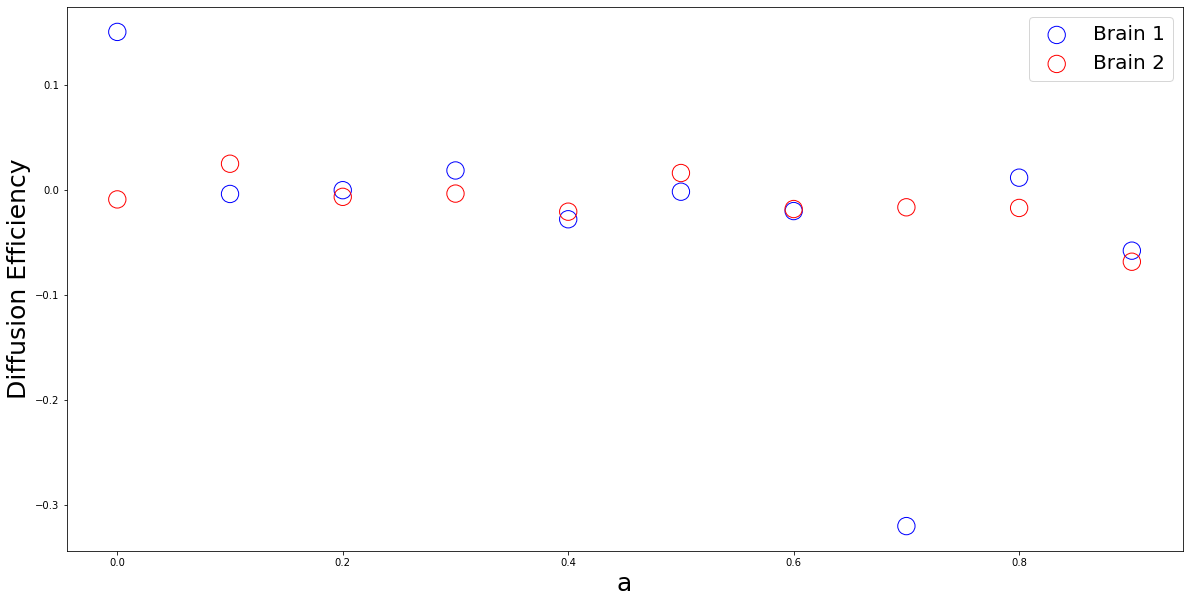

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x, E_diff_BR1,marker='o',color='b',s=300,facecolors='none')
ax.scatter(x,E_diff_BR2, marker='o', color='r',s=300,facecolors='none')
ax.legend(labels=['Brain 1', 'Brain 2'],fontsize=20,loc='best')
ax.set_ylabel('Diffusion Efficiency',fontsize=25)
ax.set_xlabel('a',fontsize=25)
plt.show()

# QUESTION (2.5) What conclusions can you derive from previous plots? Compare diffusion and global efficiencies within a single graph and across both graphs. [5%]

Diffusion Efficiency of Brain 1 is higher without thresholding. When thresholding starts, Brain 1 shows significant decrease while Brain 2 doesn't. At threshold value 0.6 both Brains have the same efficiency value. But at threshold 0.7 Brain 1 drops its efficiency quickly while Brain 2 stays almost the same. According to graph Brain 2 has more stability than Brain 1 against any connection loss. Interestingly after losing its 0.8 of nodes Brain 1 increases diffusion efficiency as if its remaining nodes (central) has high degree centrality. Brain 2 has high degree centrality at its all nodes; they are strongly connected with each other so it is hard to decrease diffusion. At threshold 0.9 both brains have nearly the same efficiency. To conclude, Brain 2 doesn't show any abnormal drop or increase during thresholding but Brain 1 acts notably different. Brain 2 is better than Brain 1 against attacks.

Global Efficiency of Brain 2 is higher than Brain 1 without thresholding. While Brain 1 shows significant decrease after threshold 0.4 Brain 2 decreases significantly at threshold 0.5. Meaning that Brain 1 is more vulnerable than Brain 2. Brain 1's global efficiency decreases easier than Brain 2. At 0.2 and 0.5 global efficiency of Brain 1 is higher than Brain 2 but still Brain 1 decreases earlier than Brain 2 and keeps decreasing at each threshold value. On the contrary Brain 2 shows slow decrease at each threshold value compare to Brain 1. At 0.9 threshold Brain 2 show increase while Brain 1 almost loses its entire global efficiency.   

# QUESTION (2.6) Plot a morphospace b [1] for the set of thresholded brain graphs at α ∈ [0 : 0.1 : 0.9], where the x-axis denotes E dif f and y-axis denotes E glob. Use two different colors to compare the two thresholded graph sets derived from each brain graph, respectively. [10%]

In [14]:
#get graph sets of BRAIN 1 and BRAIN 2 for each threshold
B1=[]
B2=[]
for g in t_brain_1:
    B1.append(nx.from_numpy_matrix(g).copy())
for g in t_brain_2:
    B2.append(nx.from_numpy_matrix(g).copy())
sampled_networks=[B1,B2]

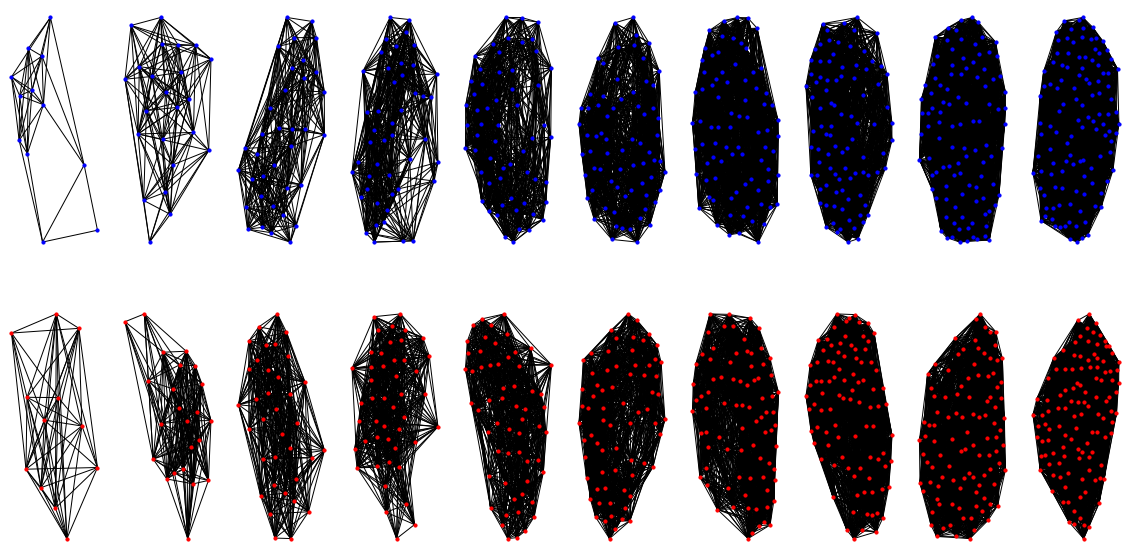

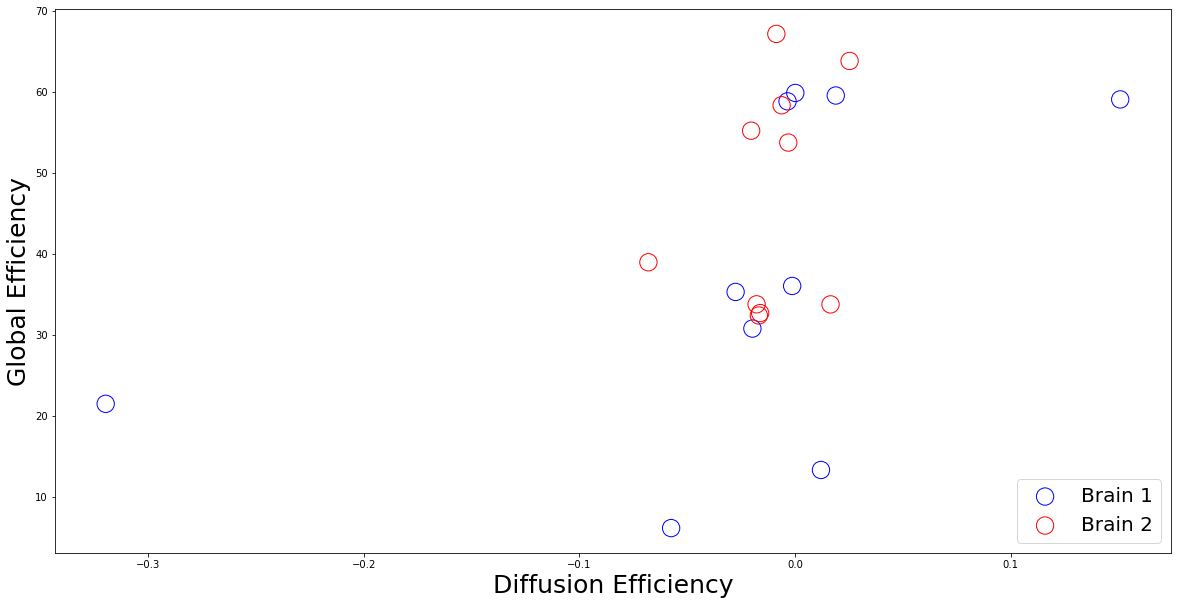

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=10,figsize=(20, 10))
#ax = axes.flatten()
x=E_diff_BR1
y=E_glob_BR1

n_color='blue'
for i in range(2):
    for j in range(10):
        #G = nx.path_graph(sampled_networks[i][j])
        #pos = nx.spectral_layout(G)
        nx.draw(sampled_networks[i][j], ax=axes[i][j],node_color=n_color, node_size=10) # Drawing the graph, assign randomized colors
        #axes[i][j].set_axis_off()
    n_color='red'
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(E_diff_BR1,E_glob_BR1,marker='o',color='b',s=300,facecolors='none')
ax.scatter(E_diff_BR2,E_glob_BR2, marker='o', color='r',s=300,facecolors='none')
ax.legend(labels=['Brain 1', 'Brain 2'],fontsize=20,loc='lower right')
ax.set_ylabel('Global Efficiency',fontsize=25)
ax.set_xlabel('Diffusion Efficiency',fontsize=25)
plt.show()

# OUESTION (2.7) Discuss the information flow efficiency for both brain graphs based on your morphospace plot. [5%]

Brain 2 has better information flow efficiency than Brain 1. Only Brain 1 shows (L, L) in both efficiency measures. None of the brains show (L, H) (Global, Diffusion) value at any threshold. Brain 1 has the lowest information flow efficiency. Brain 2 captures the right upper part of the space (H, H) having the high efficiency values in both measures at most of the threshold values. Brain 1 has the lowest information flow efficiency at 0.9 threshold and captures right upper and lower parts of the plot at other thresholds (mostly right lower (L, L)). Brain 2 shows higher information flow efficiency at any threshold value.

# QUESTION (3.1) Write a function called selfDiffuse that takes (i) a weighted graph adjacency matrix (i.e., similarity matrix) W and outputs the diffused matrix W ? (check algorithm fig:3.). Make sure that your algorithm automatically sets the optimal number of diffusion iterations t ? as explained in the paper [2]. [10%]

In [16]:
def selfDiffuse(W):    
    #create graph from adjacency matrix
    G = nx.from_numpy_matrix(W)
    #assign number of nodes to N
    N=G.number_of_nodes()
    #Initialize D matrix NxN 
    D= np.zeros((N, N), float)
    #create I matrix
    I= np.zeros((N, N), float)
    np.fill_diagonal(I, 1)
    #Initialize variables 
    ik_element=[]
    #loop for D matrix diagonal elements in formula D(i,i)=sigma[W(i,k)]
    for i in range(N):
        ik_sum=0
        for k in range(N):
            #sum k elements for each i in W
                ik_sum +=W[i][k]
        #store summed k elements for D        
        ik_element.append(ik_sum)
    
    #create D diagonal matrix            
    an_array = np.array(ik_element)
    np.fill_diagonal(D, an_array)
    #calculate P=D**-1W
    P = np.linalg.inv(D) @ W
    #smoothing step (formula from paper Wang et.al Lemma 4.1)        
    for t in range(42):
        Wt= np.zeros((N, N), float)
        Wt = np.add((np.subtract(I, np.linalg.matrix_power(P,t)) @ np.linalg.inv(np.subtract(I, P))) ,(W @ np.linalg.matrix_power(P,t)))
        #self-diffusion
        Wstar=Wt @ np.linalg.inv(D)
     
    return Wstar

# QUESTION (3.2) Run selfDiffuse on both brain graph adjacency matrices ‘Exercise 2 data/brainGraph1.mat’ and ‘Exercise 2 data/ brainGraph2.mat’. For each brain graph, visualize both original and diffused matrices. [10%]

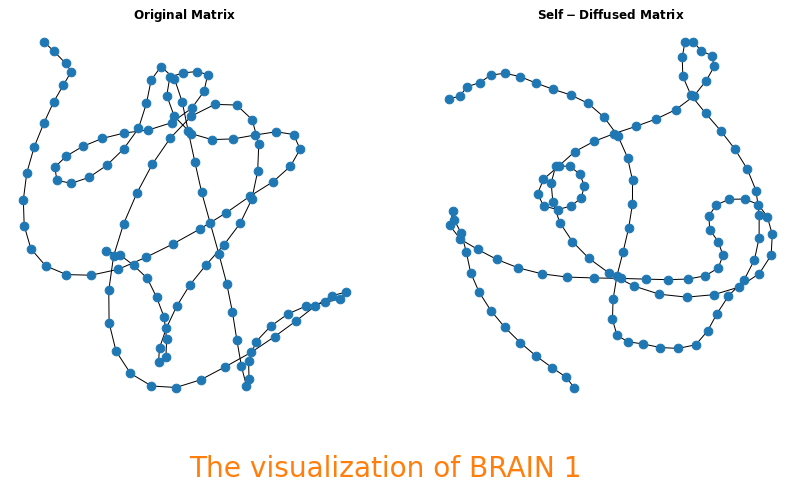

In [17]:
mat = scipy.io.loadmat('brainGraph1.mat')
#extract only matrix from mat file whose field name is A 
#get adjacency matrix of HW2 Brain Graph 1
adjacencyMatrix=mat['W']
GW = nx.from_numpy_matrix(adjacencyMatrix)
original=nx.path_graph(GW)

Wstar=selfDiffuse(adjacencyMatrix)
GWstar = nx.from_numpy_matrix(Wstar)
SD=nx.path_graph(GWstar)

# Creating the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = axes.flatten()
ax[0].title.set_text(r"$\mathbf{Original\ Matrix}$")
ax[1].title.set_text(r"$\mathbf{Self-Diffused\ Matrix}$")
graph=[original,SD]
# Iterating in the pair
for i in range(2):
    nx.draw(graph[i], ax=ax[i],node_size=75) # Drawing the graph, assign randomized colors
    ax[i].set_axis_off()
    
# Plotting with the caption
text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1')
fig.text(0.5, 0, "The visualization of BRAIN 1", **text_kwargs)
plt.show()

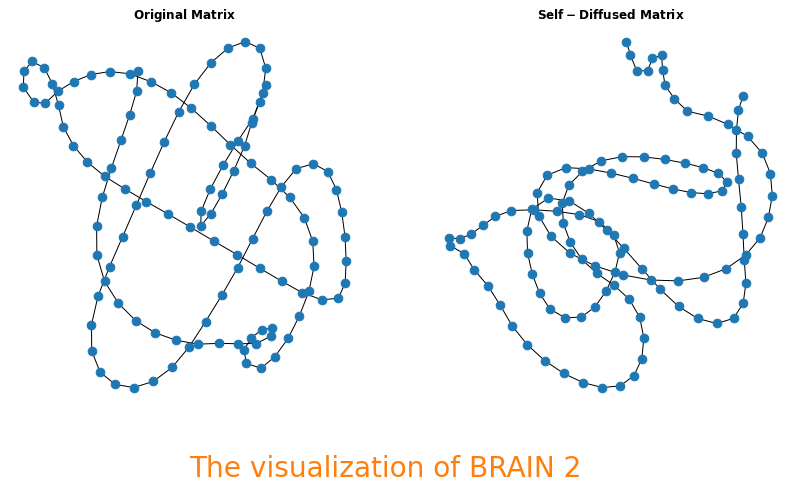

In [18]:
mat = scipy.io.loadmat('brainGraph2.mat')
#extract only matrix from mat file whose field name is A 
#get adjacency matrix of HW2 Brain Graph 1
adjacencyMatrix=mat['W']
GW = nx.from_numpy_matrix(adjacencyMatrix)
original=nx.path_graph(GW)

Wstar=selfDiffuse(adjacencyMatrix)
GWstar = nx.from_numpy_matrix(Wstar)
SD=nx.path_graph(GWstar)

# Creating the plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = axes.flatten()
ax[0].title.set_text(r"$\mathbf{Original\ Matrix}$")
ax[1].title.set_text(r"$\mathbf{Self-Diffused\ Matrix}$")
graph=[original,SD]
# Iterating in the pair
for i in range(2):
    nx.draw(graph[i], ax=ax[i],node_size=75) # Drawing the graph, assign randomized colors
    ax[i].set_axis_off()
    
# Plotting with the caption
text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1')
fig.text(0.5, 0, "The visualization of BRAIN 2", **text_kwargs)   
plt.show()

# QUESTION (3.3) Given the 2 images taken from the Berkeley Segmentation Data Set c , generate the segmentation maps of each image using the Normalized Cut Python code https://github.com/marktao99/python/blob/master/CVP/samples/ncut.py. Display each original image and its corresponding output segmentation map. [10%]

In [19]:
from PIL import Image
from pylab import *
from numpy import *
from scipy.cluster.vq import *


def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    if sum(abs(S-S.T)) > 1e-10:
        print ('not symmetric')
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = diag(1 / sqrt(rowsum + 1e-6))
    L = dot(D,dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V


def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    
    return W

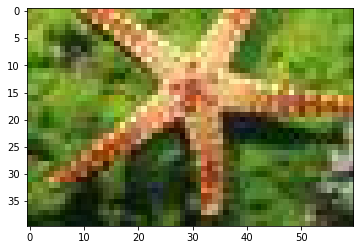

In [62]:
im=array(Image.open("image1.jpg"))
imshow(im)

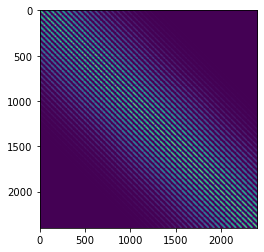

In [63]:
W=ncut_graph_matrix(im)
imshow(W)

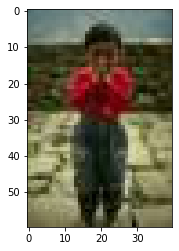

In [64]:
im=array(Image.open("image2.jpg"))
imshow(im)

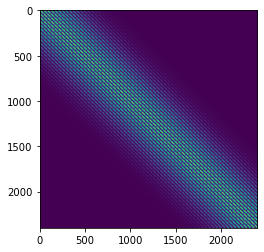

In [65]:
W=ncut_graph_matrix(im)
imshow(W)

# QUESTION (3.4) For each image, change the Normalized Cut Python by applying self-Diffuse to the similarity matrix W, then use W ? to perform the normalized cut and output the image segmentation map. For each image, display 5 differrent normalized cut segmentation maps when varying the diffusion threshold from t = 1 to t = 2 × t ? (similar to Fig 1 in [2] and Fig fig:4 below). [10%]

In [66]:
#updated self-diffuse function for ncut
def selfDiffuse_threshold(W,threshold):    
    #create graph from adjacency matrix
    G = nx.from_numpy_matrix(W)
    #assign number of nodes to N
    N=G.number_of_nodes()
    #Initialize D matrix NxN 
    D= np.zeros((N, N), float)
    #create I matrix
    I= np.zeros((N, N), float)
    np.fill_diagonal(I, 1)
    #Initialize variables 
    ik_element=[]
    #loop for D matrix diagonal elements in formula D(i,i)=sigma[W(i,k)]
    for i in range(N):
        ik_sum=0
        for k in range(N):
            #sum k elements for each i in W
                ik_sum +=W[i][k]
        #store summed k elements for D        
        ik_element.append(ik_sum)
    
    #create D diagonal matrix            
    an_array = np.array(ik_element)
    np.fill_diagonal(D, an_array)
    #calculate P=D**-1W
    P = np.linalg.inv(D) @ W
    #smoothing step (formula from paper Wang et.al Lemma 4.1)        
    for t in range(threshold):
        Wt= np.zeros((N, N), float)
        Wt = np.add((np.subtract(I, np.linalg.matrix_power(P,t)) @ np.subtract(I, P)) ,(W @ np.linalg.matrix_power(P,t)))
        #self-diffusion
        Wstar=Wt @ np.linalg.inv(D)
     
    return Wstar

In [67]:
#updated ncut function with self-diffuse
from PIL import Image
from pylab import *
from numpy import *
from scipy.cluster.vq import *


def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # check for symmetry
    if sum(abs(S-S.T)) > 1e-10:
        print ('not symmetric')
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = diag(1 / sqrt(rowsum + 1e-6))
    L = dot(D,dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V

def personalized_ncut_graph_matrix(im,t,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * exp(-d/sigma_d)
    Wstar=selfDiffuse_threshold(W,t)
    return Wstar

In [68]:
#calling image1 with sea-star
t = np.arange(1, 2*2, 1)
im=array(Image.open("image1.jpg"))
images=[]
images.append(im)

for i in t:
    #updated version of ncut with self-diffuse parameters are image array and threshold
    Wstar=personalized_ncut_graph_matrix(im,i)
    images.append(Wstar)

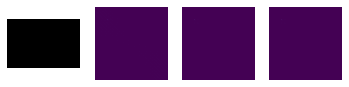

In [59]:
# Creating the plot
fig, axes = plt.subplots(1,4)
ax = axes.flatten()
for i in range(len(images)):
    ax[i].imshow(images[i]) # Drawing the graph, assign randomized colors
    ax[i].set_axis_off()

In [70]:
#calling image2 with child
im=array(Image.open("image2.jpg"))
images=[]
images.append(im)

for i in t:
    #updated version of ncut with self-diffuse parameters are image array and threshold
    Wstar=personalized_ncut_graph_matrix(im,i)
    images.append(Wstar)

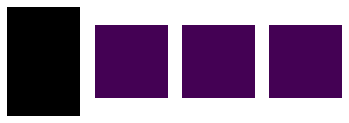

In [71]:
# Creating the plot
fig, axes = plt.subplots(1,4)
ax = axes.flatten()
for i in range(len(images)):
    ax[i].imshow(images[i]) # Drawing the graph, assign randomized colors
    ax[i].set_axis_off()